<a href="https://colab.research.google.com/github/Navya78sd/House-Price-Prediction/blob/main/timetable_generation_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Method (a): Backtracking with Heuristics (MRV + LCV) ---
Time taken: 0.000146 seconds
Backtracks: 0
Solution found:
  CHEM101    -> Tue_9-10   in R2
  CS101      -> Mon_9-10   in R1
  CS102      -> Mon_10-11  in R1
  MATH101    -> Tue_9-10   in R1
  PHYS101    -> Mon_10-11  in R2

--------------------------------------------------

--- Method (b): Backtracking with Forward Checking ---
Time taken: 0.000978 seconds
Backtracks: 0
Solution found:
  CHEM101    -> Tue_9-10   in R2
  CS101      -> Mon_9-10   in R1
  CS102      -> Mon_10-11  in R1
  MATH101    -> Tue_9-10   in R1
  PHYS101    -> Mon_10-11  in R2

--------------------------------------------------

--- Performance Comparison ---
Metric       | (a) Heuristics  | (b) Fwd Checking
-----------------------------------------------
Time (s)     | 0.000146        | 0.000978       
Backtracks   | 0               | 0              

--- Performance Graphs ---


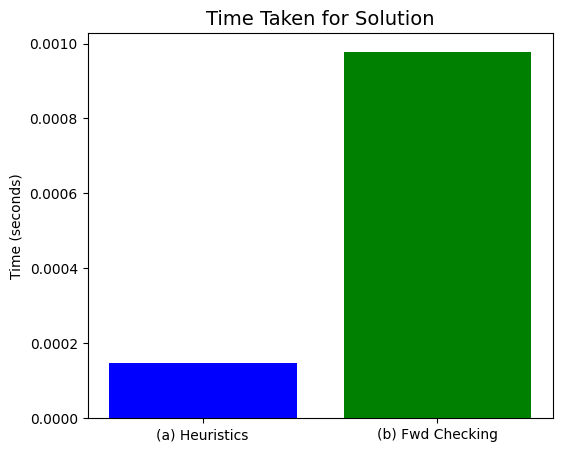

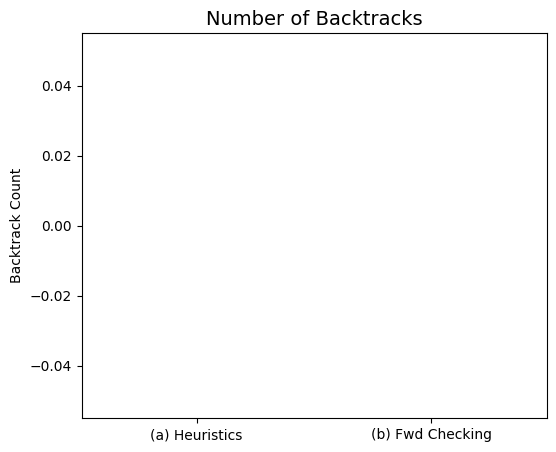

In [1]:
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

class CSP:
    """
    This class defines the structure for the Timetable CSP.
    """
    def __init__(self, variables, domains, constraints):
        self.variables = variables  # List of courses, e.g., ['CS101', 'MATH101']
        self.domains = domains      # Dict: {'CS101': [('Mon9', 'R1'), ...], ...}
        self.constraints = constraints # Dict: {'CS101': [constraint_func, ...], ...}
        self.num_backtracks = 0

    def is_consistent(self, variable, value, assignment):
        """Check if a value is consistent with the current assignment."""
        for constraint in self.constraints.get(variable, []):
            if not constraint(variable, value, assignment):
                return False
        return True

# --- 1. Problem Formulation (Assumptions) ---

def setup_timetable_csp():
    """
    This function defines the specific problem instance.
    """
    # 1. Define Courses, Professors, and Student Groups
    courses = ['CS101', 'CS102', 'MATH101', 'PHYS101', 'CHEM101']
    professors = {
        'CS101': 'Prof. Ada',
        'CS102': 'Prof. Babbage',
        'MATH101': 'Prof. Ada',       # Prof. Ada teaches two courses
        'PHYS101': 'Prof. Curie',
        'CHEM101': 'Prof. Babbage'  # Prof. Babbage teaches two courses
    }
    groups = {
        'CS101': ['Group1', 'Group2'],
        'CS102': ['Group2', 'Group3'],
        'MATH101': ['Group1', 'Group3'],
        'PHYS101': ['Group1'],
        'CHEM101': ['Group2']
    }

    # 2. Define Time Slots and Rooms
    time_slots = ['Mon_9-10', 'Mon_10-11', 'Tue_9-10', 'Tue_10-11']
    rooms = ['R1', 'R2']

    # 3. Define Variables and Domains
    variables = courses

    # The domain for each variable is the set of all possible (slot, room) pairs
    possible_assignments = [(slot, room) for slot in time_slots for room in rooms]
    domains = {course: possible_assignments[:] for course in courses}

    # 4. Define Constraints

    def constraint_professor(var, val, assignment):
        """A professor cannot teach two courses at the same time."""
        (slot, room) = val
        prof = professors[var]
        for assigned_var, assigned_val in assignment.items():
            if professors[assigned_var] == prof and assigned_val[0] == slot:
                return False  # Conflict
        return True

    def constraint_group(var, val, assignment):
        """A student group cannot attend two courses at the same time."""
        (slot, room) = val
        var_groups = groups[var]
        for assigned_var, assigned_val in assignment.items():
            if assigned_val[0] == slot: # If at the same time
                assigned_groups = groups[assigned_var]
                if any(g in assigned_groups for g in var_groups):
                    return False # Conflict
        return True

    def constraint_room(var, val, assignment):
        """A room cannot host two courses at the same time."""
        (slot, room) = val
        for assigned_var, assigned_val in assignment.items():
            if assigned_val == val: # (slot, room) pair is identical
                return False # Conflict
        return True

    # Assign constraints to each variable
    constraints = {}
    for var in variables:
        constraints[var] = [constraint_professor, constraint_group, constraint_room]

    return CSP(variables, domains, constraints)


# --- 2. Solvers ---

# --- 2a. Backtracking with Heuristics ---

def select_unassigned_mrv(csp, assignment):
    """Selects the unassigned variable with the Minimum Remaining Values (MRV)."""
    unassigned = [v for v in csp.variables if v not in assignment]
    return min(unassigned, key=lambda var: len(csp.domains[var]))

def order_domain_lcv(csp, var, assignment):
    """Orders domain values by the Least Constraining Value (LCV)."""
    def count_conflicts(value):
        conflicts = 0
        for v_neighbor in csp.variables:
            if v_neighbor not in assignment and v_neighbor != var:
                if value in csp.domains[v_neighbor]:
                    conflicts += 1
        return conflicts

    return sorted(csp.domains[var], key=count_conflicts)

def backtracking_with_heuristics(csp, assignment={}):
    """Solves the CSP using Backtracking + MRV and LCV."""
    if len(assignment) == len(csp.variables):
        return assignment  # Solution found

    var = select_unassigned_mrv(csp, assignment)

    for value in order_domain_lcv(csp, var, assignment):
        if csp.is_consistent(var, value, assignment):
            assignment[var] = value
            result = backtracking_with_heuristics(csp, assignment)
            if result:
                return result

            # Backtrack
            csp.num_backtracks += 1
            del assignment[var]

    return None

# --- 2b. Backtracking with Forward Checking ---

def forward_checking(csp, var, value, domains_copy, assignment):
    """Prunes domains of unassigned neighbors after assigning var=value."""
    pruned_values = {neighbor: [] for neighbor in csp.variables}

    for neighbor in csp.variables:
        if neighbor not in assignment and neighbor != var:
            for neighbor_val in list(domains_copy[neighbor]): # Iterate over a copy
                # Create a temporary assignment to check against
                temp_assignment = assignment.copy()
                temp_assignment[var] = value

                if not csp.is_consistent(neighbor, neighbor_val, temp_assignment):
                    domains_copy[neighbor].remove(neighbor_val)
                    pruned_values[neighbor].append(neighbor_val)

            if not domains_copy[neighbor]:
                return False, pruned_values # Domain wipeout, failure

    return True, pruned_values # Success


def backtracking_with_forward_checking(csp, assignment={}, domains=None):
    """Solves the CSP using Backtracking + Forward Checking."""
    if domains is None:
        domains = copy.deepcopy(csp.domains)

    if len(assignment) == len(csp.variables):
        return assignment # Solution found

    var = [v for v in csp.variables if v not in assignment][0]

    for value in list(domains[var]): # Iterate over a copy of the domain list
        if csp.is_consistent(var, value, assignment):
            assignment[var] = value

            domains_copy = copy.deepcopy(domains)
            success, pruned = forward_checking(csp, var, value, domains_copy, assignment)

            if success:
                result = backtracking_with_forward_checking(csp, assignment, domains_copy)
                if result:
                    return result

            # Backtrack
            csp.num_backtracks += 1
            del assignment[var]
            # Domains are restored by not passing the modified copy up

    return None

# --- 3. Plotting Function ---

def plot_csp_results(time_a, backtracks_a, time_b, backtracks_b):
    """Generates bar charts for CSP performance comparison."""
    labels = ['(a) Heuristics', '(b) Fwd Checking']
    colors = ['blue', 'green']

    times = [time_a, time_b]
    backtracks = [backtracks_a, backtracks_b]

    print("\n--- Performance Graphs ---")

    # Plot 1: Time
    plt.figure(figsize=(6, 5))
    plt.bar(labels, times, color=colors)
    plt.title('Time Taken for Solution', fontsize=14)
    plt.ylabel('Time (seconds)')
    plt.show()

    # Plot 2: Backtracks
    plt.figure(figsize=(6, 5))
    plt.bar(labels, backtracks, color=colors)
    plt.title('Number of Backtracks', fontsize=14)
    plt.ylabel('Backtrack Count')
    plt.show()


# --- 4. Main Execution and Comparison ---

def run_csp_experiments():
    print("--- Method (a): Backtracking with Heuristics (MRV + LCV) ---")
    csp_a = setup_timetable_csp()
    start_a = time.perf_counter()
    solution_a = backtracking_with_heuristics(csp_a, {})
    time_a = time.perf_counter() - start_a

    print(f"Time taken: {time_a:.6f} seconds")
    print(f"Backtracks: {csp_a.num_backtracks}")
    if solution_a:
        print("Solution found:")
        for course, (slot, room) in sorted(solution_a.items()):
            print(f"  {course:<10} -> {slot:<10} in {room}")
    else:
        print("No solution found.")

    print("\n" + "-"*50 + "\n")

    print("--- Method (b): Backtracking with Forward Checking ---")
    csp_b = setup_timetable_csp()
    start_b = time.perf_counter()
    solution_b = backtracking_with_forward_checking(csp_b, {})
    time_b = time.perf_counter() - start_b

    print(f"Time taken: {time_b:.6f} seconds")
    print(f"Backtracks: {csp_b.num_backtracks}")
    if solution_b:
        print("Solution found:")
        for course, (slot, room) in sorted(solution_b.items()):
            print(f"  {course:<10} -> {slot:<10} in {room}")
    else:
        print("No solution found.")

    print("\n" + "-"*50 + "\n")

    # --- Performance Comparison ---
    print("--- Performance Comparison ---")
    print(f"{'Metric':<12} | {'(a) Heuristics':<15} | {'(b) Fwd Checking':<15}")
    print("-" * 47)
    print(f"{'Time (s)':<12} | {time_a:<15.6f} | {time_b:<15.6f}")
    print(f"{'Backtracks':<12} | {csp_a.num_backtracks:<15} | {csp_b.num_backtracks:<15}")
    # --- Plot Results ---
    plot_csp_results(time_a, csp_a.num_backtracks, time_b, csp_b.num_backtracks)

# --- Run the experiments ---
run_csp_experiments()